In [30]:
import numpy as np
import pandas as pd
import scipy.io

from sklearn.decomposition import NMF
from EGD_optimizer import EGD_optim
from optuna_opt import optuna_tune
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

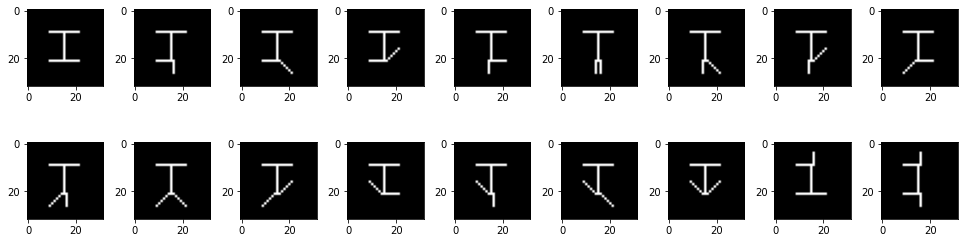

In [31]:
swimmer_dict = scipy.io.loadmat('Q:\AUH-HAEM-FORSK-MutSigDLBCL222\external_data\swimmer_data.mat')

swimmer_mat = swimmer_dict['Y']

num_row = 2
num_col = 9
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(18):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(swimmer_mat[ :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

swimmer_mat = pd.DataFrame(swimmer_mat.reshape(1024, 256).T).replace([1,39], [0,1])

In [32]:
parts = 17

class NMF_AE(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        #1024 > parts < 1024

        # Building an linear encoder
        self.enc1 = torch.nn.Linear(1024, dim1, bias = False)
          
        # Building an linear decoder 
        self.dec1 = torch.nn.Linear(dim1, 1024, bias = False)
            

    def forward(self, x):
        x = torch.nn.functional.relu(self.enc1(x))
        x = self.dec1(x)
        return x
        
def train_EGD(epochs, model, x_train, loss_function, optimizer_enc, optimizer_dec, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    loss_list = []
    for epoch in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        loss_p = 0
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)
          loss_p =+ loss.item()

          optimizer_enc.zero_grad() #clear old gradients
          optimizer_dec.zero_grad()
          
          loss.backward() #backpropagation
          
          optimizer_enc.step()#update params
          optimizer_dec.step()

        loss_list.append(loss_p)

    plt.plot(range(epochs), loss_list)
    plt.show() 
    return(model)

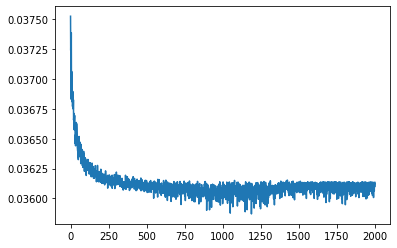

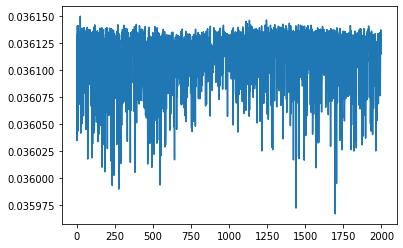

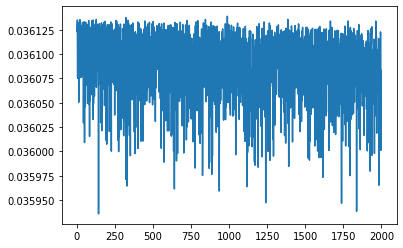

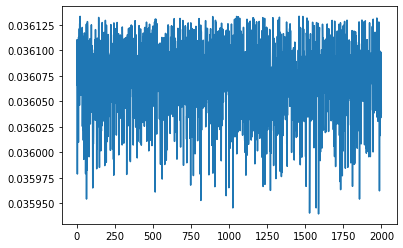

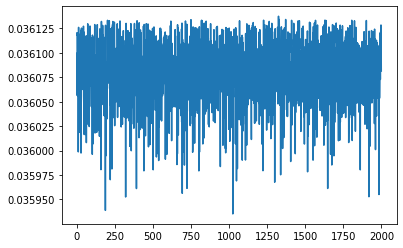

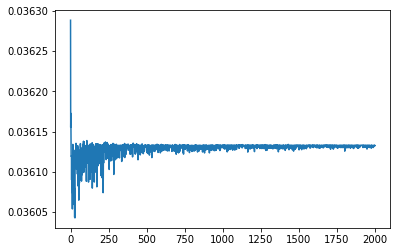

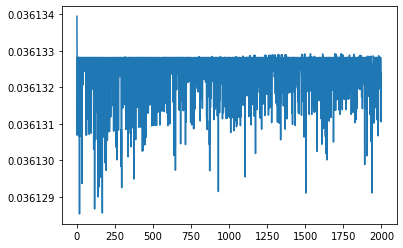

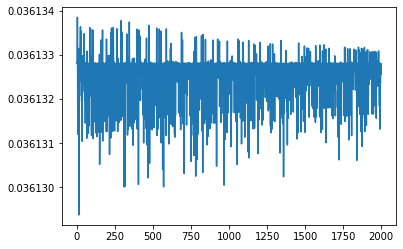

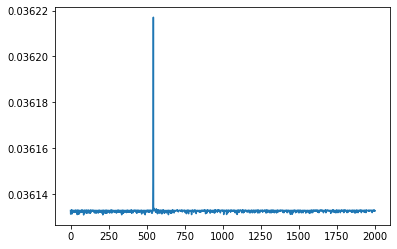

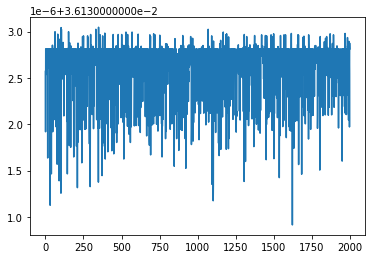

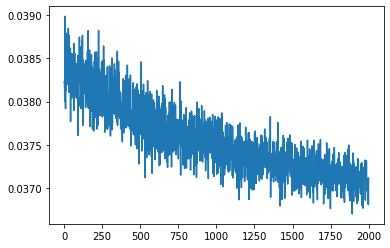

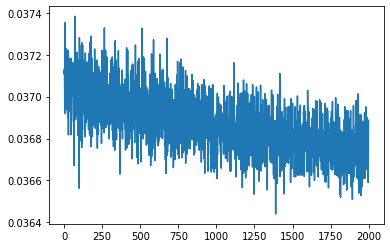

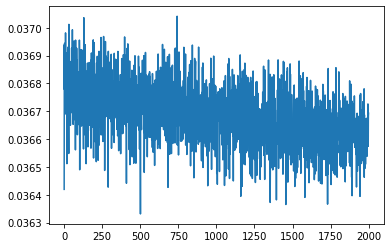

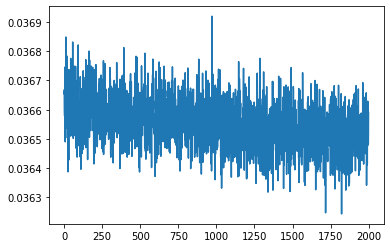

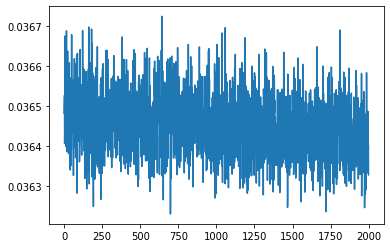

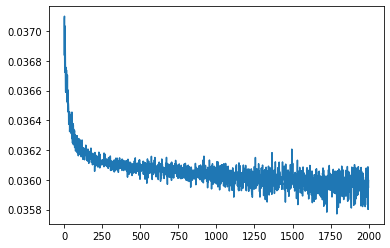

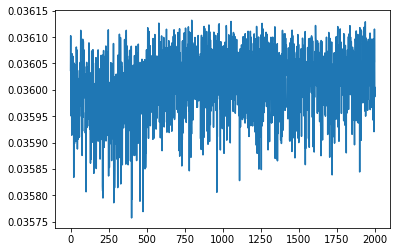

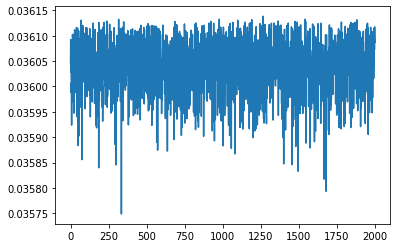

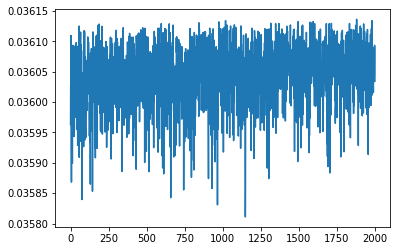

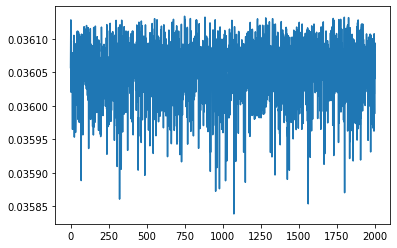

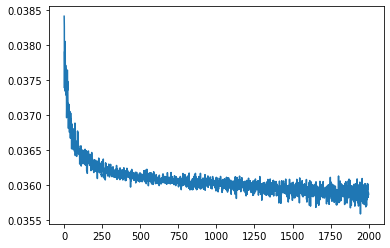

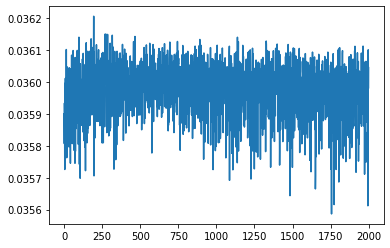

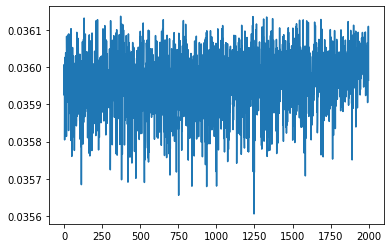

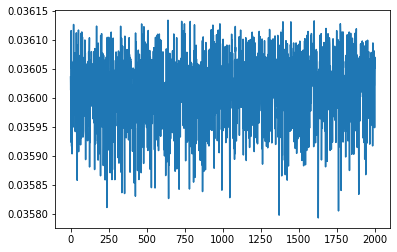

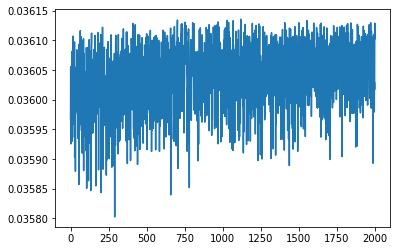

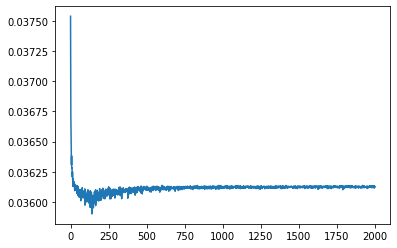

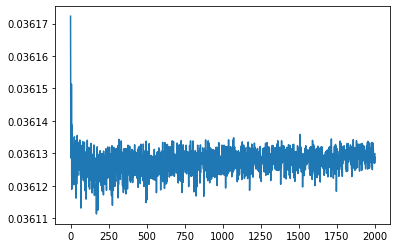

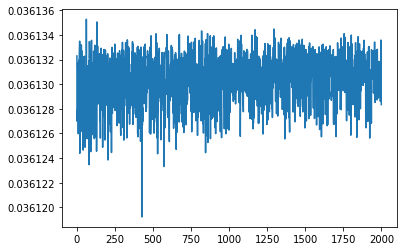

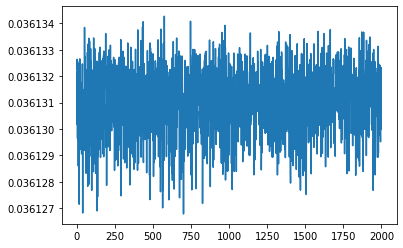

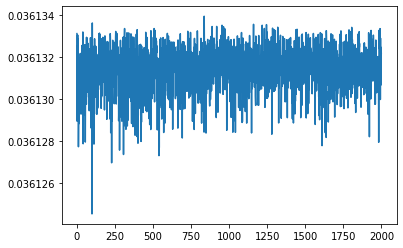

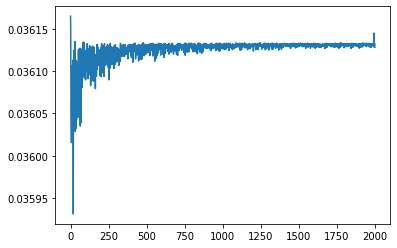

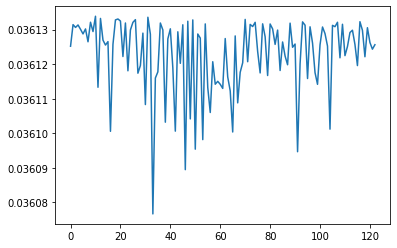

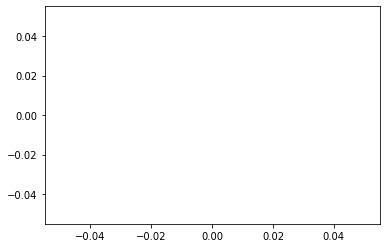

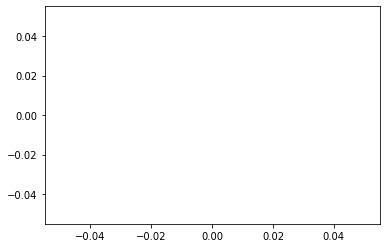

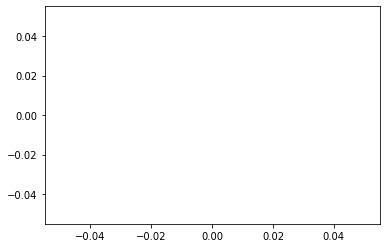

[W 2022-08-29 15:32:36,784] Trial 6 failed, because the objective function returned nan.


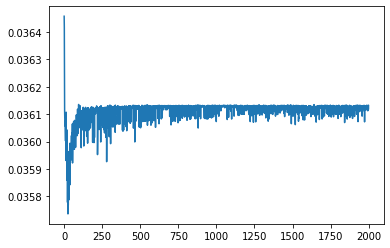

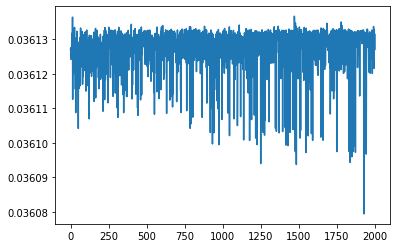

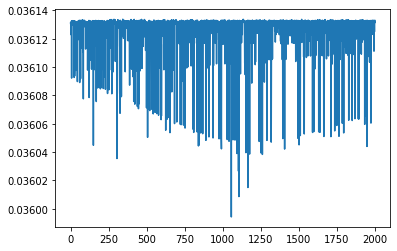

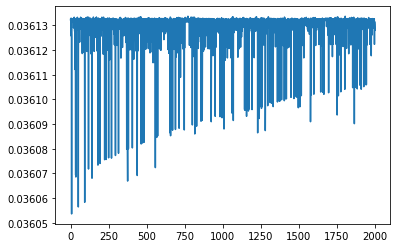

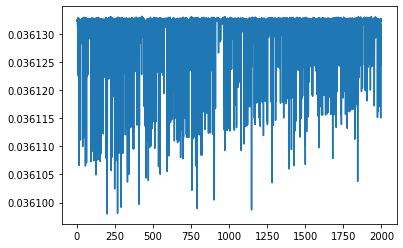

In [33]:
params = optuna_tune(swimmer_mat, parts, model_name = "EGD")

In [34]:
lr1 = 0.1
lr2 = params['lr2']
batch_size = params['batch_size']
model = NMF_AE(dim1 = parts)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
#optimizer_dec = torch.optim.Adam(model.dec1.parameters(), lr = lr1)#EGD_optim(model.dec1.parameters(), lr = lr2)

optimizer_enc =  EGD_optim(model.parameters(), lr = lr2)

'''
train_EGD(epochs = 2000, 
            model = model, 
            x_train = swimmer_mat, 
            loss_function = loss_function, 
            optimizer_enc = optimizer_enc,
            optimizer_dec = optimizer_dec,
            batch_size = batch_size)
            '''

'\ntrain_EGD(epochs = 2000, \n            model = model, \n            x_train = swimmer_mat, \n            loss_function = loss_function, \n            optimizer_enc = optimizer_enc,\n            optimizer_dec = optimizer_dec,\n            batch_size = batch_size)\n            '

In [35]:

#turn the training data into a tensor
x_train_tensor = torch.tensor(swimmer_mat.values, 
                            dtype = torch.float32)

#this is what loads makes the updates batch-wise insted of the full data matrix
trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                            batch_size=batch_size, 
                                            shuffle=True)

loss_list = []
for epoch in range(5000):
    model.train() #set model in traning mode (alternative model.eval())
    loss_p = 0
    for data in trainloader:
        # Output of Autoencoder
        reconstructed = model(data)
        
        # Calculating the loss function
        loss = loss_function(reconstructed, data)
        loss_p =+ loss.item()

        optimizer_enc.zero_grad() #clear old gradients
        #optimizer_dec.zero_grad()
        
        loss.backward() #backpropagation
        
        optimizer_enc.step()#update params
        #optimizer_dec.step()

    loss_list.append(loss_p)

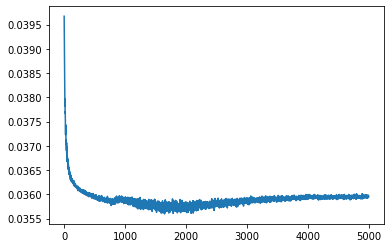

In [36]:
plt.plot(range(5000), loss_list)
plt.show() 

swimmers = model.dec1.weight.data    
swimmers = swimmers.numpy().reshape(32, 32, 17)

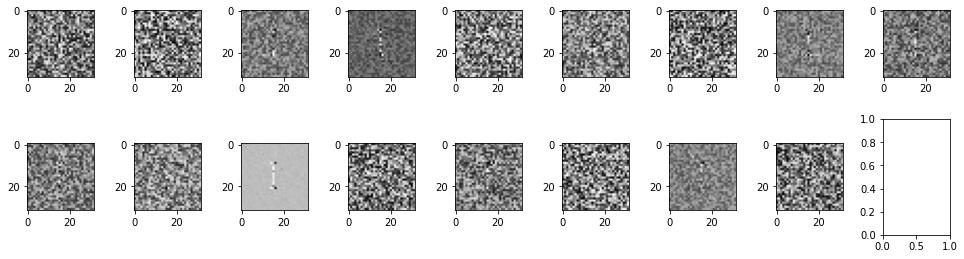

In [37]:

num_row = 2
num_col = 9
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(parts):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(swimmers[ :, :, i], cmap='gray')
plt.tight_layout()
plt.show()